In [1]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from inf.pimlp import *
from tests.test_pimlp import *
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
sns.set()
def tight_layout(plt):
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

In [4]:
X = torch.linspace(-np.pi, np.pi).reshape(-1, 1)
y = torch.sin(X) #.reshape(-1)
X = torch.cat([X, torch.ones_like(X)], dim=1)

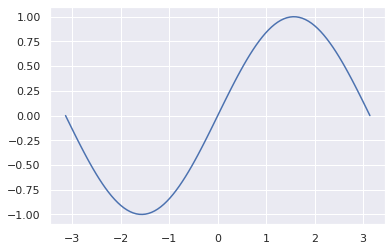

In [5]:
plt.plot(X[:, 0], y)

In [9]:
lrs = [0.1]
momenta = [0, 0.6]
# momenta = [0]
batches = [32]
lns = [False, True]
# lns = [False]
wds = [0, 0.1]
# wds = [0]
bias_alphas = [0, 1]
# bias_alphas = [0]
gclips = [0, 0.1]
gclip_perp_params = [False, True]

In [14]:
kws = dict(
  lrs = [0.02],
  momenta = [0, 0.6],
  batches = [32],
#   lns = [True],
  lns = [True],
  wds = [0, 0.1],
  # wds = [0]
  bias_alphas = [0, 1],
  gclips = [0, 0.1],
  gclip_perp_params = [False, True],
  damps = [0],
  last_layer_alpha = [1, 10],
  # bias_alphas = [0],
)

In [29]:
kws = dict(
  lrs = [0.1],
  momenta = [0],
  batches = [32],
#   lns = [True],
  lns = [True],
  wds = [0, 0.1],
  # wds = [0]
  bias_alphas = [0, 1],
  gclips = [0, 0.1],
  gclip_perp_params = [False, True],
  damps = [0],
  last_layer_alpha = [1, 10],
  # bias_alphas = [0],
)

In [26]:
def getlosses(L, kws, widths=None, rank=2, T=100, lr_drop_T=3, lr_drop_ratio=0.5, bias_lr_mult=4, first_layer_lr_mult=5, first_layer_alpha=0.5):
  losses = {}
  if widths is None:
    widths = [10000, 20000]
  # combos = product(lrs, momenta, batches, lns, wds, bias_alphas, gclips, gclip_perp_params, damps)
  combos = product(*kws.values())
  for i, comb in list(enumerate(combos)):
    (lr, mom, batch, ln, wd, bias_alpha, gclip, gclip_per_param, damp, last_layer_alpha) = comb
    if gclip == 0 and gclip_per_param:
      continue
    fig = plt.figure()
    plt.ylabel('loss')
    plt.xlabel('iter')
    torch.manual_seed(1)
    np.random.seed(1)
    infnet = InfPiMLP(d=2, dout=1, L=L, r=rank, initbuffersize=1000,
                      bias_alpha=bias_alpha, quiet=True, layernorm=ln,
                     first_layer_alpha=first_layer_alpha,
                     last_layer_alpha=last_layer_alpha)

    # need to do finite net first, since record_pgdlim changes infnet
    for width in widths:
      losses[(comb, width)] = record_pgdfin(infnet, X, y, lr, width, T,
                                             cuda=True, center=True,
                                             batchsize=batch, seed=0, momentum=mom, dampening=damp,
                                             wd=wd, lr_drop_T=lr_drop_T, lr_drop_ratio=lr_drop_ratio,
                                             bias_lr_mult=bias_lr_mult, first_layer_lr_mult=first_layer_lr_mult,
                                             gclip=gclip, gclip_per_param=gclip_per_param)
      arr = np.copy(losses[(comb, width)])
      arr = np.nan_to_num(arr, nan=1e10, posinf=1e10, neginf=-1e10)
      arr[arr>10] = np.nan
      plt.plot(arr, label=str(width))
  #   if (lr, batch, np.inf) not in losses:
    losses[(comb, np.inf)] = record_pgdlim(infnet, X, y, lr, T,
                                           cuda=True, batchsize=batch, seed=0,
                                           momentum=mom, wd=wd, dampening=damp,
                                           lr_drop_T=lr_drop_T, lr_drop_ratio=lr_drop_ratio,
                                           bias_lr_mult=bias_lr_mult, first_layer_lr_mult=first_layer_lr_mult,
                                           gclip=gclip, gclip_per_param=gclip_per_param)
    arr = np.copy(losses[(comb, np.inf)])
    arr = np.nan_to_num(arr, nan=1e10, posinf=1e10, neginf=-1e10)
    arr[arr>10] = np.nan
    plt.plot(arr, '--', label='inf')
    plt.legend()
  #   plt.title(f'lr={lr}, mom={mom}, bsz={batch}, ln={ln}, wd={wd}, bias_alpha={bias_alpha}, '
  #             f'gclip={gclip}, per_param={gclip_per_param}')
    print(dict(zip(kws.keys(), comb)))
    plt.show()
  return losses

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


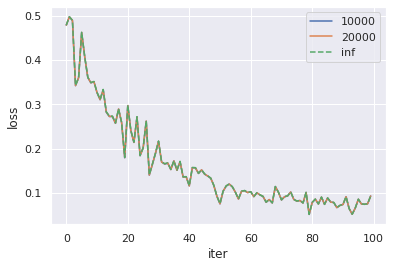

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


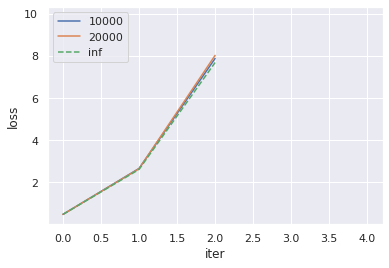

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


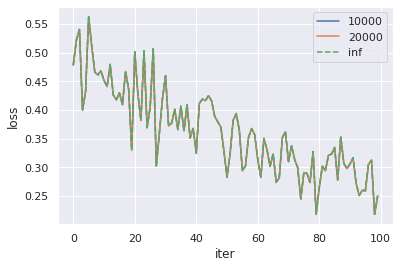

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


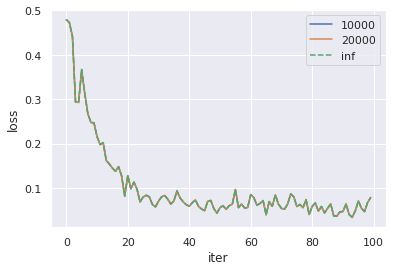

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


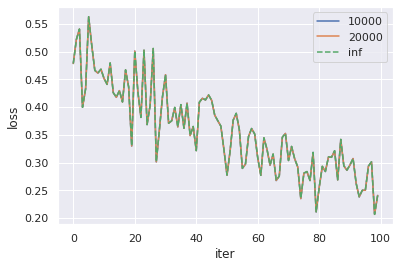

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


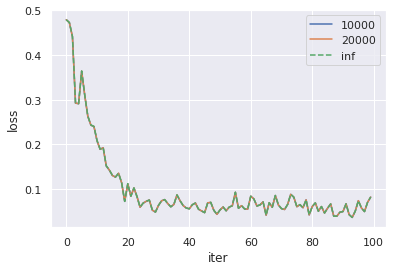

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


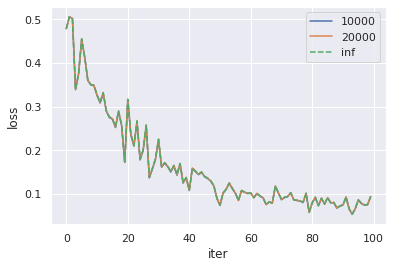

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


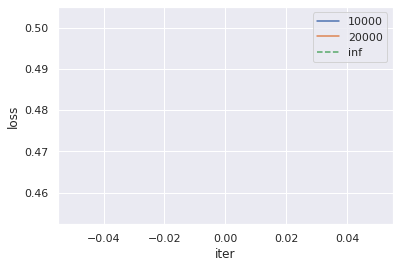

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


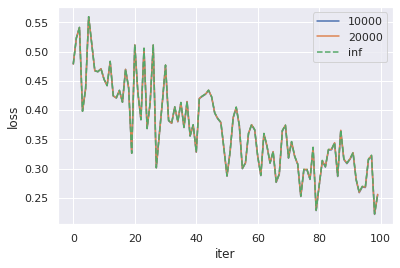

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


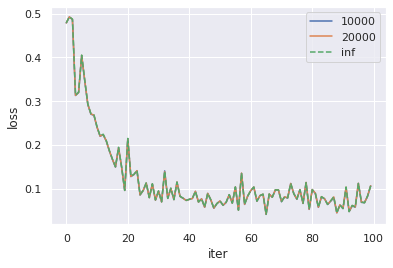

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


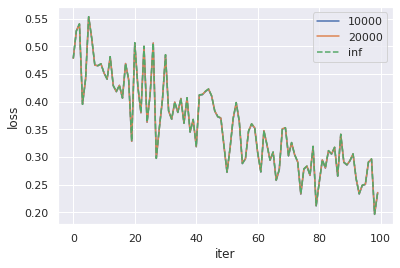

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


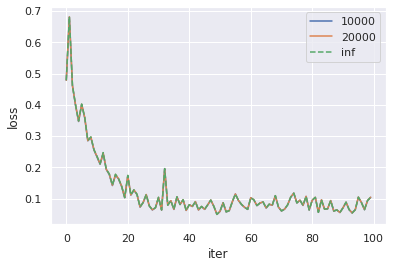

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


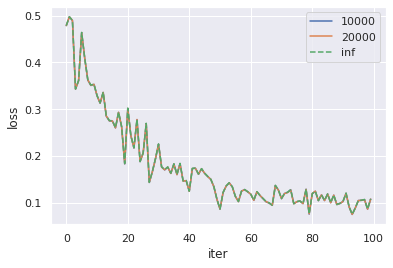

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


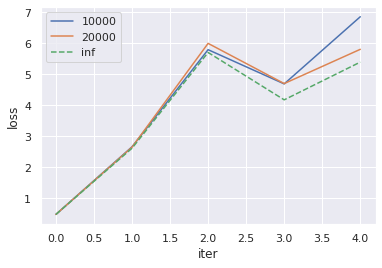

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


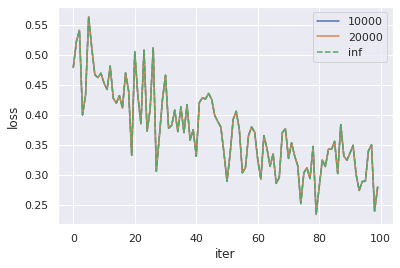

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


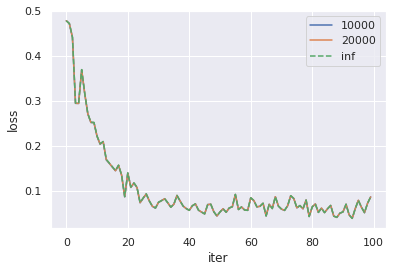

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


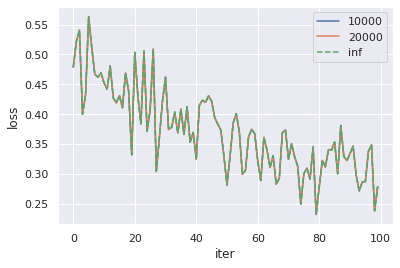

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


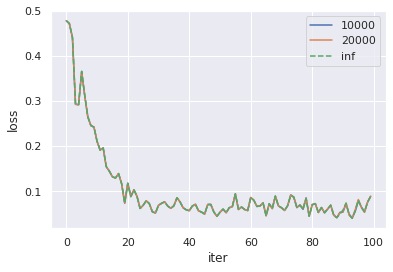

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


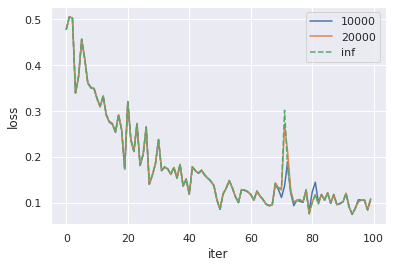

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


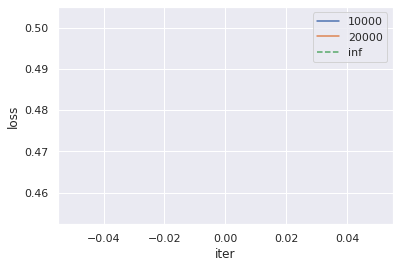

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


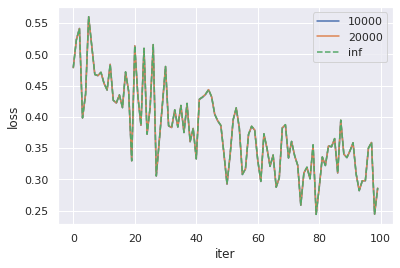

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


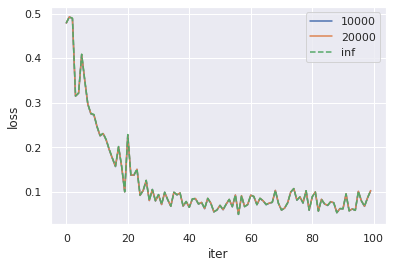

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


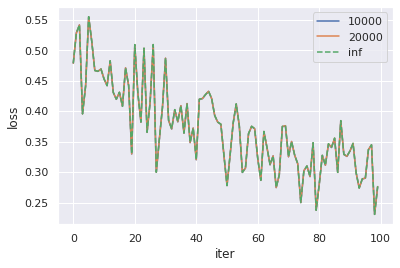

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


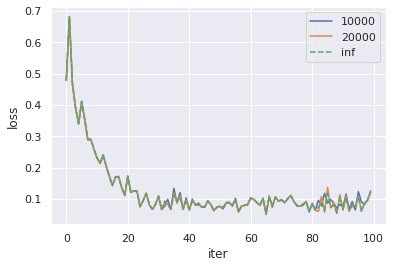

In [30]:
_ = getlosses(1, kws)

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


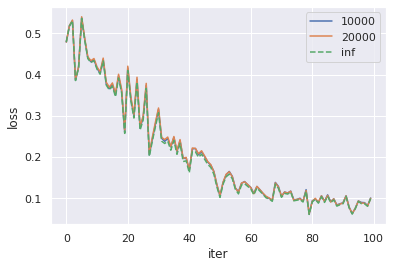

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


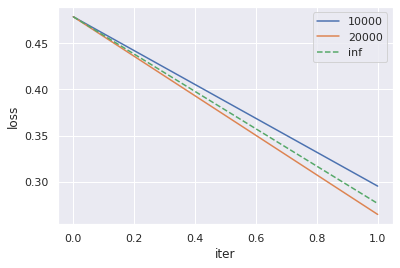

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


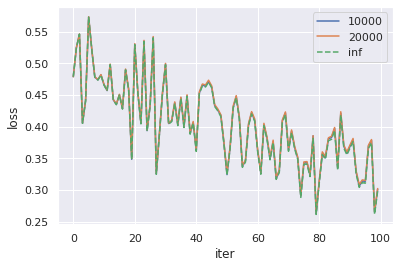

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


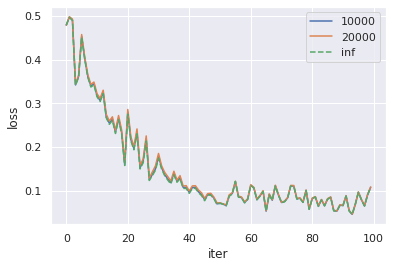

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


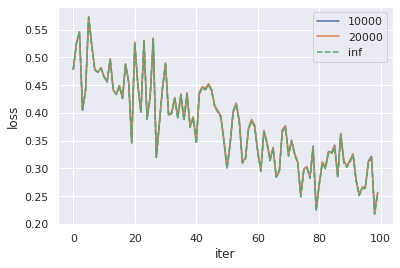

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


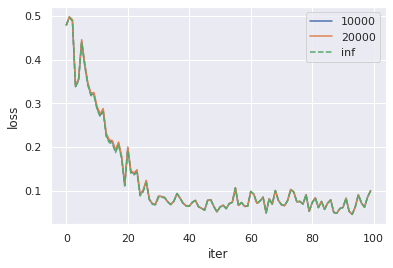

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


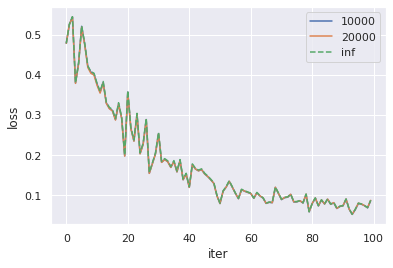

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


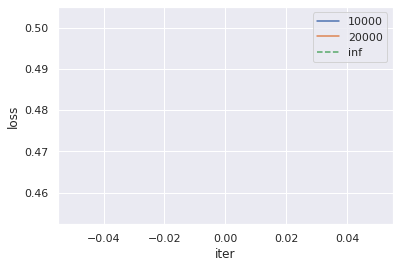

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


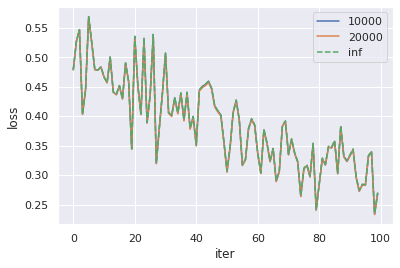

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


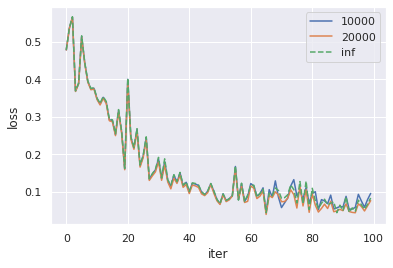

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


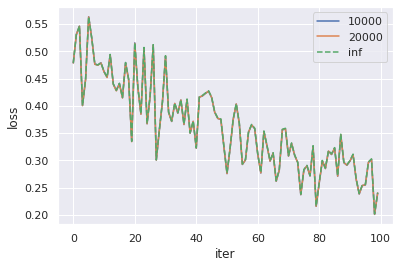

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


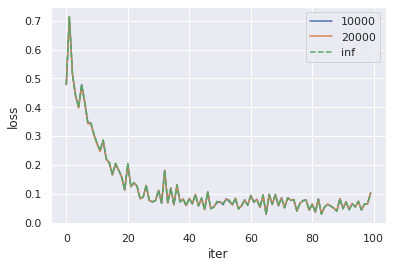

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


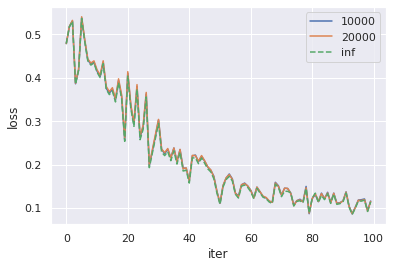

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


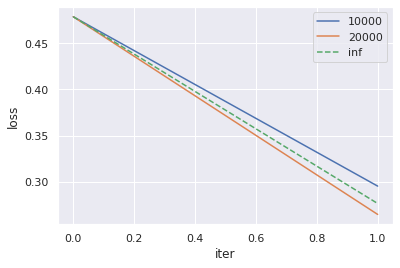

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


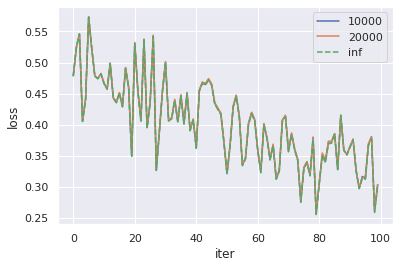

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


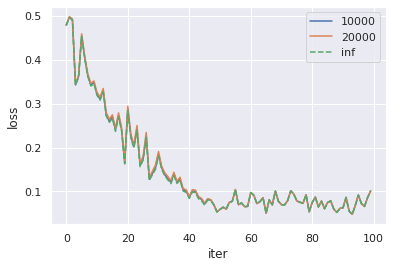

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


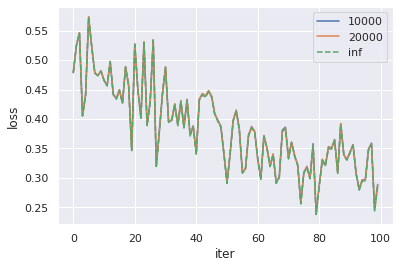

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 0, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


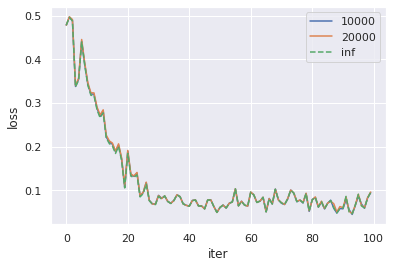

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


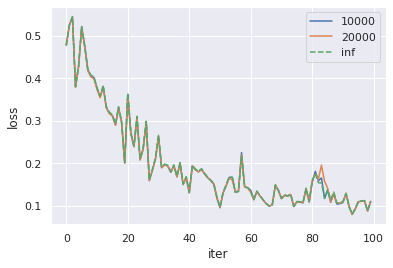

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


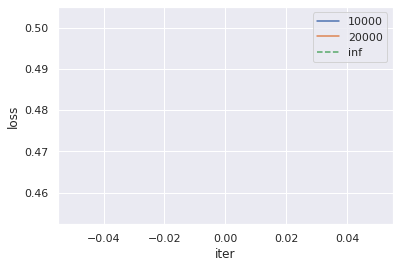

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 1}


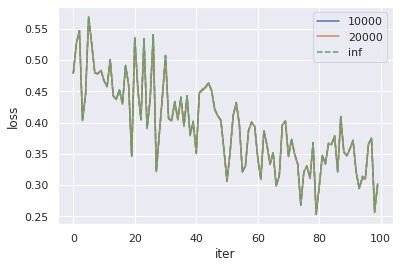

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': False, 'damps': 0, 'last_layer_alpha': 10}


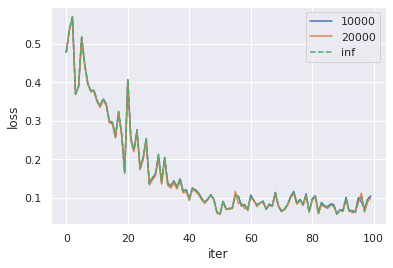

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 1}


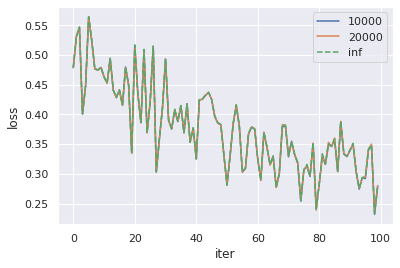

{'lrs': 0.1, 'momenta': 0, 'batches': 32, 'lns': True, 'wds': 0.1, 'bias_alphas': 1, 'gclips': 0.1, 'gclip_perp_params': True, 'damps': 0, 'last_layer_alpha': 10}


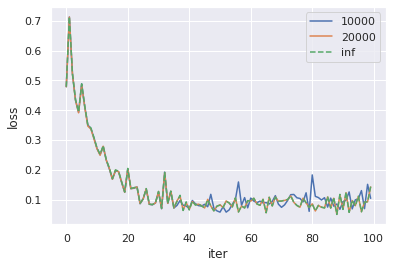

In [31]:
_ = getlosses(2, kws)